# Triangular lattice

Triangular lattice size adjust to: [4 2]
Equalize: scale_factor is not a number. Set to None.
detV = -1.0000000000000007
V = [ 1.11276641 -0.85192843 -0.89996212  0.63912416  0.63912416 -0.89996215
 -0.85192841  1.11276637]
V = [ 1.11276641 -0.85192843 -0.89996212  0.63912416  0.63912416 -0.89996215
 -0.85192841  1.11276637]
t = [0.20768617 0.27384333 0.32909682 0.12807214 0.8075829  0.32909684
 0.60086259 0.63438768 0.27384334 0.60086257 0.80758289 0.20768633
 0.1280722 ]
U = [0.15382413 1.17647249 1.14434117 1.05144495 1.05144495 1.14434118
 1.17647254 0.15382413]
V_err = 4.459850482450702
t_err = 0.5361225949127936
U_err = 0.4794406770976026


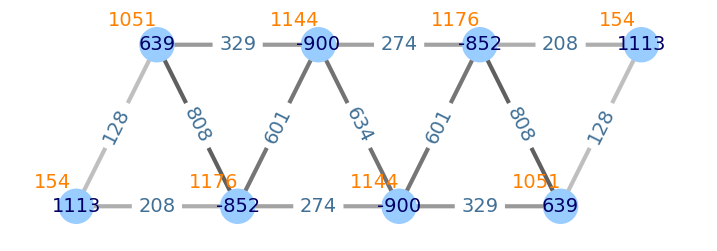

In [1]:
from Hubbard.plot import *
import numpy as np
from Hubbard.output import *

N = 16
Lx = 4
Ly = 2
d = 3
shape = 'triangular'
w = None
eqt = 'neq'
R0 = np.array([3, 3, 7.2])
G = HubbardGraph(N,
                 R0=R0,
                 lattice=np.array([Lx, Ly], dtype=int),
                 trap=(73.0219, 1000),
                 lc=1450,
                 laser=780,
                 dim=d,
                 shape=shape,
                 waist=w,
                 equalize=False,
                 eqtarget=eqt,
                 sparse=True,
                 symmetry=True,
                 lattice_symmetry=False,
                 verbosity=0)
eig_sol = eigen_basis(G)
E, W, p = eig_sol
E = E[0]
W = W[0]
p = p[0]
R = Xmat(G, W, p)

# In high dimension, X, Y, Z don't commute
# Convert list of ndarray to list of Tensor
R = [torch.from_numpy(Ri) for Ri in R]
solution = riemann_optimize(G, None, R)
V = site_order(G, solution, R)
print('detV =', la.det(V))
G.A = V.conj().T @ (E[:, None] * V) * G.V0 / G.kHz_2p

# Shift onsite potential to zero average
G.A -= np.mean(np.real(np.diag(G.A))) * \
    np.eye(G.A.shape[0])
G.U = singleband_interaction(G, V, V, W, W, p, p)
G.draw_graph(A=G.A, U=G.U)

print(f'V = {np.diag(G.A)}')
cv = np.sqrt(G.v_cost_func(G.A, None, None))
ct = np.sqrt(G.t_cost_func(G.A, None, None))
cu = np.sqrt(G.u_cost_func(G.U, None, None))
print(f'V = {np.diag(G.A)}')
print(f't = {abs(G.nn_tunneling(G.A))}')
print(f'U = {G.U}')
print(f'V_err = {cv}')
print(f't_err = {ct}')
print(f'U_err = {cu}')


In [2]:
import operator
import itertools
from scipy.spatial.distance import cdist
from ortools.linear_solver import pywraplp

x = np.array([np.diag(V.T @ R[i].numpy() @ V) / G.lc[i]
              for i in range(G.lattice_dim)]).T


def ordfun1(G, x):
    dist_mat = cdist(G.trap_centers, x, metric="euclidean")
    # dist_mat is a square matrix, result shall be a full rank matrix
    # if trap centers and WFs are 1-to-1 corresponded.
    order = np.zeros(G.Nsite, dtype=int)
    for i in range(G.Nsite):
        # Find unused site index that is closest to i-th WF
        order[i] = np.where(dist_mat[i] == np.min(
            dist_mat[i, np.delete(np.arange(G.Nsite), order[:i])]))[0]
    return order


def ordfun2(G, x):
    dist_mat = cdist(G.trap_centers, x, metric="euclidean")
    perm = permutations(range(G.Nsite))
    odx = np.arange(G.Nsite)
    a = (np.sum(dist_mat[odx, order]**2) for order in perm)

    min_index, min_value = min(enumerate(a), key=operator.itemgetter(1))
    perm = permutations(range(G.Nsite))
    order = next(x for i, x in enumerate(perm) if i == min_index)
    return order


def ordfun3(G, x):
    dist_mat = cdist(G.trap_centers, x, metric="euclidean")
    perm = permutations(range(G.Nsite))
    min_dist = np.inf
    best_order = np.arange(G.Nsite)
    for order in perm:
        odx = np.arange(G.Nsite)
        dist = np.sum(dist_mat[odx, order]**2)
        if dist < min_dist:
            min_dist = dist
            best_order = order
            if dist < 1e-6:
                break
    return best_order


def ordfun4(G, x):
    dist_mat = cdist(G.trap_centers, x, metric="euclidean")
    perm = np.array(tuple(permutations(range(G.Nsite))))
    odx = np.arange(G.Nsite)
    idx = np.argmin(tuple(np.sum(dist_mat[odx, order]**2) for order in perm))
    order = perm[idx]
    return order

def ordfun5(G, X):
    num_site = G.Nsite
    num_wf = G.Nsite
    dist_mat = cdist(G.trap_centers, X, metric="euclidean")

    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # x[i, j] is an array of 0-1 variables, which will be 1
    # if worker i is assigned to task j.
    x = {}
    for i in range(num_site):
        for j in range(num_wf):
            x[i, j] = solver.IntVar(0, 1, '')

    # Each site is assigned to exactly 1 WF.
    for i in range(num_site):
        solver.Add(solver.Sum([x[i, j] for j in range(num_wf)]) == 1)

    # Each WF is assigned to exactly 1 site.
    for j in range(num_wf):
        solver.Add(solver.Sum([x[i, j] for i in range(num_site)]) == 1)

    objective_terms = []
    for i in range(num_site):
        for j in range(num_wf):
            objective_terms.append(dist_mat[i][j]**2 * x[i, j])
    solver.Minimize(solver.Sum(objective_terms))
    status = solver.Solve()

    order = np.arange(num_site)
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        # print(f'Total cost = {solver.Objective().Value()}\n')
        for i in range(num_site):
            for j in range(num_wf):
                # Test if x[i,j] is 1 (with tolerance for floating point arithmetic).
                if x[i, j].solution_value() > 0.5:
                    # print(f'Site {i} assigned to WF {j}.' +
                    #       f' Dist: {dist_mat[i][j]}')
                    order[i] = j
    else:
        print('Warning: no solution found.')
    return order

%timeit ordfun1(G, x)
%timeit ordfun2(G, x)
%timeit ordfun3(G, x)
%timeit ordfun4(G, x)
%timeit ordfun5(G, x)

64.2 µs ± 7.96 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
183 ms ± 43.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
154 ms ± 3.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
127 ms ± 5.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.9 ms ± 64.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


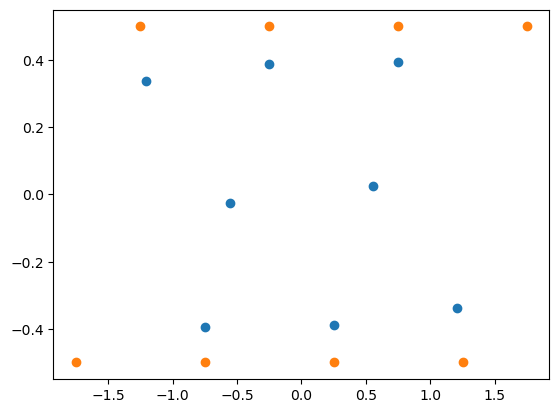

In [5]:
x = np.array([np.diag(V.T @ R[i].numpy() @ V) / G.lc[i]
              for i in range(G.lattice_dim)]).T

plt.plot(x[:, 0], x[:, 1], 'o')
plt.plot(G.trap_centers[:, 0], G.trap_centers[:, 1], 'o')


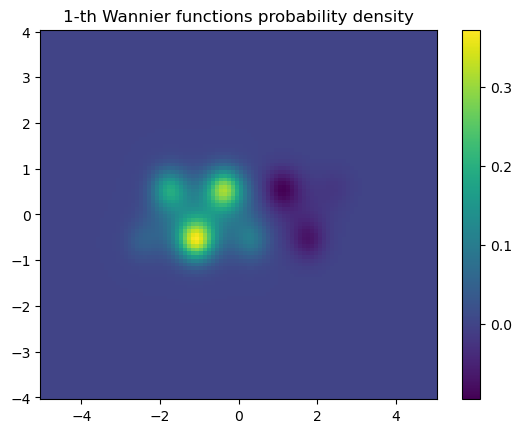

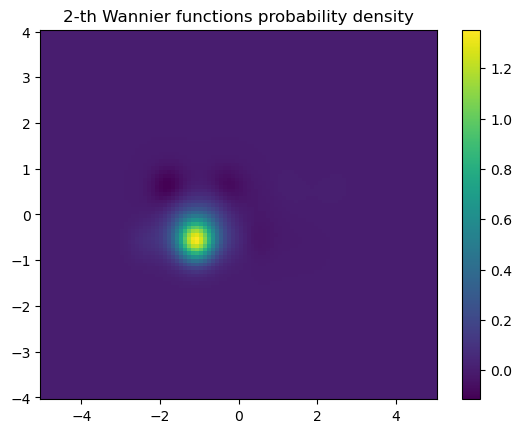

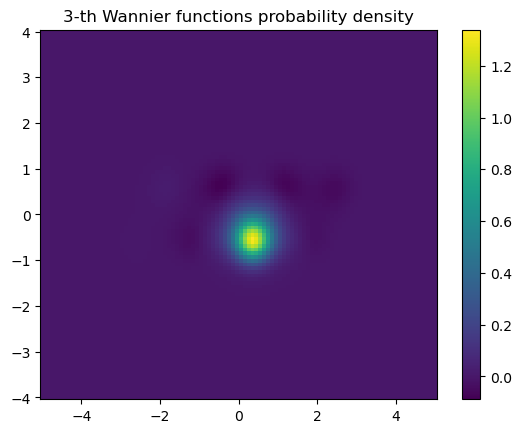

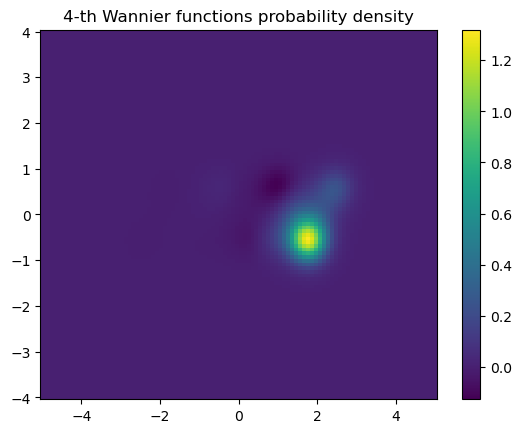

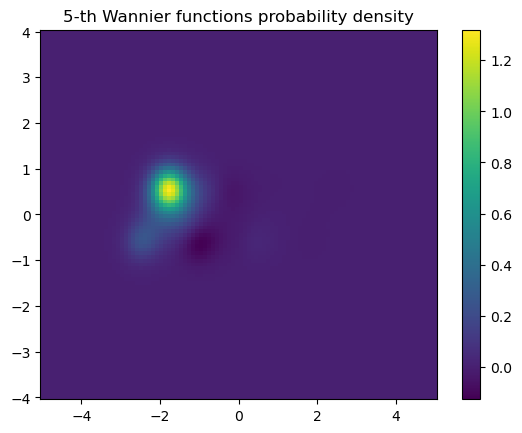

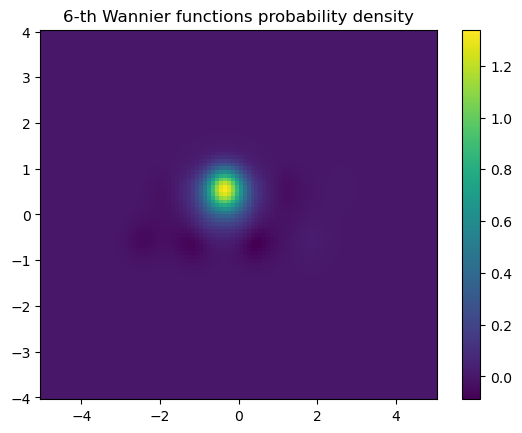

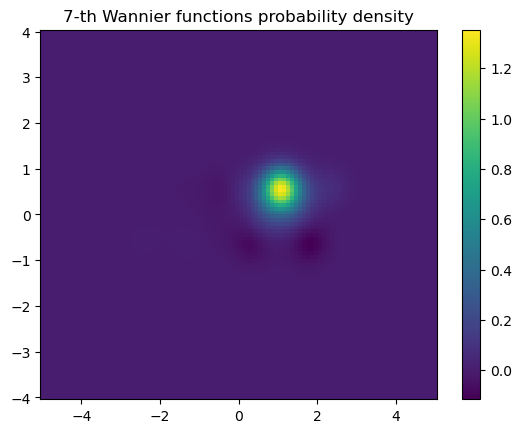

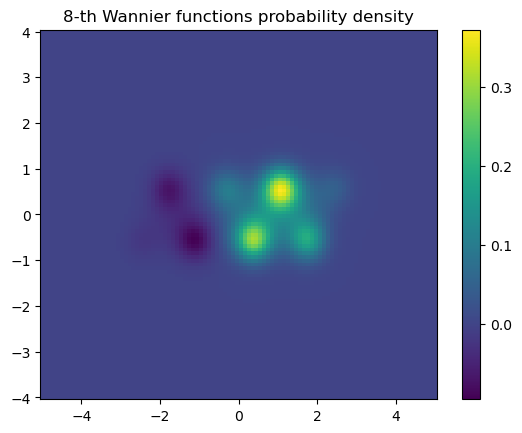

In [6]:
import matplotlib.colors as colors
from tools.fix_phase import fix_phase
import matplotlib.pyplot as plt
x = np.linspace(-5, 5, 100)
y = np.linspace(-4, 4, 100)
z = np.array([0])
wx = wannier_func(G, W, V, p, (x, y, z))
X = np.meshgrid(x, y, indexing='ij')

for i in range(G.Nsite):
    Wx = fix_phase(wx[..., 0, i], mode='svmd')
    plt.figure()
    plt.pcolormesh(*X, Wx)
    plt.colorbar()
    plt.title(f'{i+1}-th Wannier functions probability density')


Wannier function inner products:

In [7]:
from scipy.integrate import simps, dblquad
x = np.linspace(-G.R0[0], G.R0[0], 500)
y = np.linspace(-G.R0[1], G.R0[1], 500)
z = np.linspace(-G.R0[2], G.R0[2], 500)


def intgrl3d(integrand: np.ndarray, x: list[np.ndarray, np.ndarray, np.ndarray]) -> float:
    for i in range(dim):
        if x[i].size > 1:
            integrand = simps(integrand, x[i], axis=0)
        else:
            integrand = integrand[0]
    return integrand


X = [x, y, z]
wf = wannier_func(G, W, V, p, X)
print(intgrl3d(wf[:, :, :, 0] * wf[:, :, :, 4], x=X))
print(intgrl3d(wf[:, :, :, 0] * wf[:, :, :, 1], x=X))
print(intgrl3d(wf[:, :, :, 3] * wf[:, :, :, 7], x=X))
print(intgrl3d(wf[:, :, :, 6] * wf[:, :, :, 7], x=X))


1.2160785868389173e-11
2.2466674545719604e-11
-1.2161183123382768e-11
-2.2464946438715224e-11


Wannier functions are orthogonal.